### Dataset

In this homework, we will use the Students Performance in 2024 JAMB dataset from [Kaggle](https://www.kaggle.com/datasets/idowuadamo/students-performance-in-2024-jamb).

Here's a wget-able [link](https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv):

```bash
wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
```

The goal of this homework is to create a regression model for predicting the performance of students on a standardized test (column `'JAMB_Score'`).


### Preparing the dataset 

First, let's make the names lowercase:

```python
df.columns = df.columns.str.lower().str.replace(' ', '_')
```

Preparation:

* Remove the `student_id` column.
* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [19]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

sns.set_theme()

In [4]:
# Load Dataset
df = pd.read_csv("../DATASETS/jamb_exam_results.csv")
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [5]:
# makes lowercase columns
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [6]:
# Remove student_id
df.drop(columns=['student_id'], inplace=True)

In [7]:
# Check columns with missing values
df.isna().sum()

jamb_score                        0
study_hours_per_week              0
attendance_rate                   0
teacher_quality                   0
distance_to_school                0
school_type                       0
school_location                   0
extra_tutorials                   0
access_to_learning_materials      0
parent_involvement                0
it_knowledge                      0
age                               0
gender                            0
socioeconomic_status              0
parent_education_level          891
assignments_completed             0
dtype: int64

In [8]:
# Fill missing values
df.fillna(value=0, inplace=True)
df.isna().sum()

jamb_score                      0
study_hours_per_week            0
attendance_rate                 0
teacher_quality                 0
distance_to_school              0
school_type                     0
school_location                 0
extra_tutorials                 0
access_to_learning_materials    0
parent_involvement              0
it_knowledge                    0
age                             0
gender                          0
socioeconomic_status            0
parent_education_level          0
assignments_completed           0
dtype: int64

In [9]:
# Split 60/20/20
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

In [10]:
len(df_train), len(df_test), len(df_val)

(3000, 1000, 1000)

In [11]:
# DV
dv = DictVectorizer(sparse=True)

In [12]:
# turn the dataframes into matrices.
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the `jamb_score` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `study_hours_per_week` <-
* `attendance_rate`
* `teacher_quality`
* `distance_to_school`

In [16]:
dt = DecisionTreeClassifier(max_depth=1)
dt

DecisionTreeClassifier(max_depth=1)

In [18]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

In [19]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- study_hours_per_week <= 18.50
|   |--- class: 118
|--- study_hours_per_week >  18.50
|   |--- class: 190



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 22.13
* 42.13
* 62.13 <-
* 82.12

In [21]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf

RandomForestClassifier(n_estimators=10, random_state=1)

In [22]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [26]:
def rmse(y, y_pred):
    error = (y - y_pred)
    sqerror = np.square(error)
    mse = sqerror.mean()
    return round(np.sqrt(mse), 2)

In [35]:
y_pred = rf.predict(X_val)

In [36]:
rmse(y_val, y_pred)

65.51

In [38]:
root_mean_squared_error(y_val, y_pred), root_mean_squared_error(y_test, y_pred)

(65.51460142594168, 70.5409880849425)

In [31]:
# With n_jobs=-1
rf2 = RandomForestClassifier(n_estimators=10, random_state=1, n_jobs=-1)
rf2

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=1)

In [32]:
rf2.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=1)

In [39]:
y_pred = rf2.predict(X_val)
rmse(y_val, y_pred)

65.51

In [40]:
root_mean_squared_error(y_val, y_pred), root_mean_squared_error(y_test, y_pred)

(65.51460142594168, 70.5409880849425)

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

- 10 <-
- 25
- 80
- 200

In [ ]:
rmse_scores = []
estimators = range(10, 210, 10)
for n_est in estimators:
    rf = RandomForestClassifier(n_estimators=n_est, random_state=1)
    rf.fit(X_train, y_train)
    # Predict
    y_pred = rf.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    rmse_scores.append({'n_estimator': n_est, 'rmse': rmse})

df_rmse_scores = pd.DataFrame(rmse_scores)

In [45]:
df_rmse_scores

,n_estimator,rmse
0,10,65.514601
1,20,59.101777
2,30,58.222358
3,40,57.335966
4,50,56.740127
5,60,55.923296
6,70,55.157991
7,80,54.671098
8,90,55.321162
9,100,55.104646


## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25 <-

In [47]:
max_depths = [10, 15, 20, 25]
rmse_scores2 = []
estimators = range(10, 210, 10)
for md in tqdm(max_depths):
    for n_est in estimators:
        rf = RandomForestClassifier(n_estimators=n_est, max_depth=md, random_state=1)
        rf.fit(X_train, y_train)
        # Predict
        y_pred = rf.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        rmse_scores2.append({'max_depth': md,'n_estimator': n_est, 'rmse': rmse})

df_rmse_scores2 = pd.DataFrame(rmse_scores2)
df_rmse_scores2

  0%|          | 0/4 [00:00<?, ?it/s]

,max_depth,n_estimator,rmse
0,10,10,58.248167
1,10,20,57.386514
2,10,30,55.233151
3,10,40,54.071157
4,10,50,54.560251
...,...,...,...
75,25,160,55.651172
76,25,170,55.273294
77,25,180,55.378173
78,25,190,55.379437


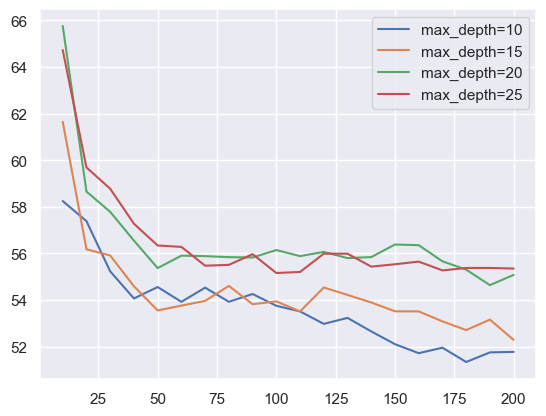

In [50]:
for d in max_depths:
    df_subset = df_rmse_scores2[df_rmse_scores2.max_depth == d]
    
    plt.plot(df_subset.n_estimator, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()
plt.show()

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `study_hours_per_week` <-
* `attendance_rate`
* `distance_to_school`
* `teacher_quality`

In [20]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1) 
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [21]:
pd.DataFrame(list(zip(dv.get_feature_names_out(), rf.feature_importances_)), columns=['Feature', 'Importance'])\
    .sort_values('Importance', ascending=False).reset_index(drop=True)

,Feature,Importance
0,study_hours_per_week,0.248354
1,attendance_rate,0.149729
2,distance_to_school,0.136486
3,teacher_quality,0.082682
4,age,0.069311
5,assignments_completed,0.031517
6,socioeconomic_status=High,0.025714
7,parent_involvement=High,0.022919
8,it_knowledge=High,0.017719
9,parent_education_level=Secondary,0.016957


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3 <-
* 0.1
* Both give equal value

In [22]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [25]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

eta_keys = [0.3, 0.1]

evals_result = {}
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [29]:
%%capture output

model = xgb.train(xgb_params, dtrain, evals=watchlist, evals_result=evals_result, verbose_eval=5, num_boost_round=100)

In [33]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [34]:
df_score = parse_xgb_output(output)

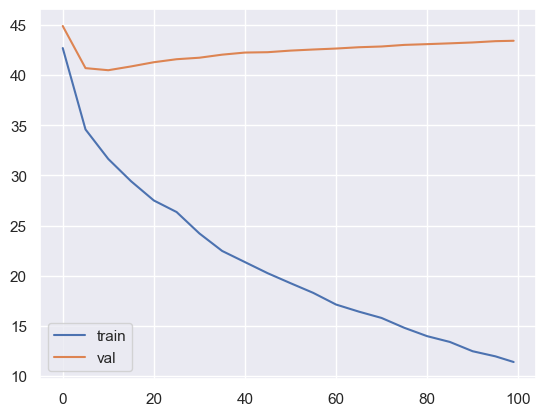

In [36]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()
plt.show()

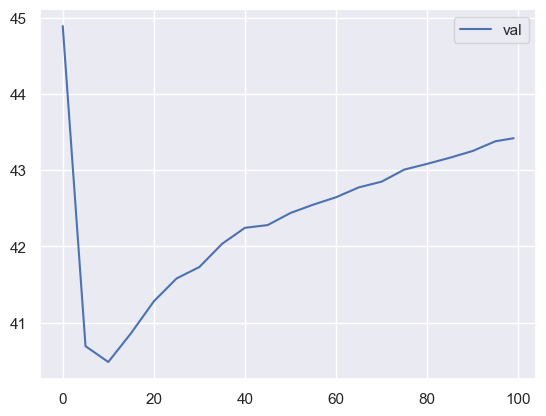

In [38]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()
plt.show()

In [39]:
scores = {}
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [40]:
def parse_xgb_output2(output):
    columns = ['iteration', 'train_rmse', 'val_rmse']
    train_rmse = list(output['train'].values())[0]
    val_rmse = list(output['val'].values())[0]

    results = list(zip(range(1, len(train_rmse) + 1), train_rmse, val_rmse))
    df = pd.DataFrame(results, columns=columns)
    return df

In [41]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output2(evals_result)
key

'eta=0.3'

In [48]:
for eta_score in tqdm(eta_keys):
    xgb_params['eta'] = eta_score
    key = 'eta=%s' % (xgb_params['eta'])
    model = xgb.train(xgb_params, dtrain, evals=watchlist, evals_result=evals_result, verbose_eval=5, num_boost_round=100)
    scores[key] = parse_xgb_output2(evals_result)

  0%|          | 0/2 [00:00<?, ?it/s]

[0]	train-rmse:42.69384	val-rmse:44.89114
[5]	train-rmse:34.57756	val-rmse:40.69096
[10]	train-rmse:31.63404	val-rmse:40.48319
[15]	train-rmse:29.41497	val-rmse:40.86107
[20]	train-rmse:27.49658	val-rmse:41.27921
[25]	train-rmse:26.34353	val-rmse:41.57975
[30]	train-rmse:24.21076	val-rmse:41.72928
[35]	train-rmse:22.46394	val-rmse:42.03417
[40]	train-rmse:21.35340	val-rmse:42.24363
[45]	train-rmse:20.24355	val-rmse:42.27966
[50]	train-rmse:19.25157	val-rmse:42.43824
[55]	train-rmse:18.28398	val-rmse:42.54750
[60]	train-rmse:17.12178	val-rmse:42.64446
[65]	train-rmse:16.41573	val-rmse:42.77416
[70]	train-rmse:15.78314	val-rmse:42.84909
[75]	train-rmse:14.80007	val-rmse:43.00760
[80]	train-rmse:13.96907	val-rmse:43.08250
[85]	train-rmse:13.39102	val-rmse:43.16297
[90]	train-rmse:12.46485	val-rmse:43.25161
[95]	train-rmse:11.95568	val-rmse:43.37919
[99]	train-rmse:11.39140	val-rmse:43.41882
[0]	train-rmse:45.49999	val-rmse:47.00533
[5]	train-rmse:40.17514	val-rmse:43.11181
[10]	train-rmse

In [49]:
scores.keys()

dict_keys(['eta=0.3', 'eta=0.1'])

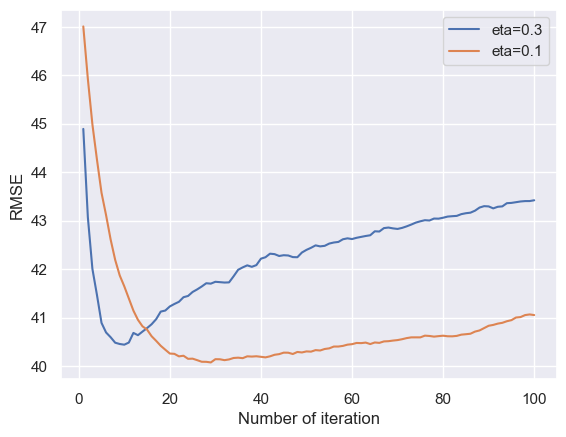

In [50]:
for key in scores.keys():
    df_score = scores[key]
    plt.plot(df_score.iteration, df_score.val_rmse, label=key)

plt.xlabel('Number of iteration')
plt.ylabel('RMSE')

plt.legend()

plt.show()

In [51]:
xgb_params['eta'] = 0.3
model = xgb.train(xgb_params, dtrain, evals=watchlist, evals_result=evals_result, verbose_eval=5, num_boost_round=100)
y_pred = model.predict(dval)
root_mean_squared_error(y_val, y_pred)

[0]	train-rmse:42.69384	val-rmse:44.89114
[5]	train-rmse:34.57756	val-rmse:40.69096
[10]	train-rmse:31.63404	val-rmse:40.48319
[15]	train-rmse:29.41497	val-rmse:40.86107
[20]	train-rmse:27.49658	val-rmse:41.27921
[25]	train-rmse:26.34353	val-rmse:41.57975
[30]	train-rmse:24.21076	val-rmse:41.72928
[35]	train-rmse:22.46394	val-rmse:42.03417
[40]	train-rmse:21.35340	val-rmse:42.24363
[45]	train-rmse:20.24355	val-rmse:42.27966
[50]	train-rmse:19.25157	val-rmse:42.43824
[55]	train-rmse:18.28398	val-rmse:42.54750
[60]	train-rmse:17.12178	val-rmse:42.64446
[65]	train-rmse:16.41573	val-rmse:42.77416
[70]	train-rmse:15.78314	val-rmse:42.84909
[75]	train-rmse:14.80007	val-rmse:43.00760
[80]	train-rmse:13.96907	val-rmse:43.08250
[85]	train-rmse:13.39102	val-rmse:43.16297
[90]	train-rmse:12.46485	val-rmse:43.25161
[95]	train-rmse:11.95568	val-rmse:43.37919
[99]	train-rmse:11.39140	val-rmse:43.41882


43.418817345871766

In [52]:
xgb_params['eta'] = 0.1
model = xgb.train(xgb_params, dtrain, evals=watchlist, evals_result=evals_result, verbose_eval=5, num_boost_round=100)
y_pred = model.predict(dval)
root_mean_squared_error(y_val, y_pred)

[0]	train-rmse:45.49999	val-rmse:47.00533
[5]	train-rmse:40.17514	val-rmse:43.11181
[10]	train-rmse:37.07490	val-rmse:41.39235
[15]	train-rmse:35.08521	val-rmse:40.61341
[20]	train-rmse:33.67389	val-rmse:40.25010
[25]	train-rmse:32.55850	val-rmse:40.12003
[30]	train-rmse:31.76039	val-rmse:40.13806
[35]	train-rmse:31.01425	val-rmse:40.16103
[40]	train-rmse:30.13427	val-rmse:40.17753
[45]	train-rmse:29.49040	val-rmse:40.27366
[50]	train-rmse:28.75947	val-rmse:40.29573
[55]	train-rmse:28.17535	val-rmse:40.40072
[60]	train-rmse:27.77264	val-rmse:40.47477
[65]	train-rmse:27.10119	val-rmse:40.47659
[70]	train-rmse:26.61847	val-rmse:40.55225
[75]	train-rmse:26.21281	val-rmse:40.62564
[80]	train-rmse:25.69135	val-rmse:40.61309
[85]	train-rmse:25.14363	val-rmse:40.66530
[90]	train-rmse:24.60413	val-rmse:40.84708
[95]	train-rmse:24.03404	val-rmse:40.99952
[99]	train-rmse:23.59704	val-rmse:41.05034


41.05034017683498